In [1]:
import glob
import numpy as np
import os
import tqdm

In [2]:
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold.mplstyle' )

<Figure size 432x288 with 0 Axes>

In [3]:
import anvil

In [4]:
import verdict

In [5]:
CHUNK_SIZE = 16
CHUNKS_PER_REGION = 32
REGION_SIZE = CHUNK_SIZE * CHUNKS_PER_REGION

# Parameters

In [6]:
image_norm = 'z'
norm_dim_value = 0

In [7]:
world_dir = '/Users/zhafen/data/minecraft/saves/aternos/world'

In [8]:
color_fp = '/Users/zhafen/data/minecraft/textures/block/colors.h5'

# Load Data

In [9]:
block_colors = verdict.Dict.from_hdf5( color_fp )

In [10]:
region_fps = glob.glob( os.path.join( world_dir, 'region', '*' ) )

In [11]:
# Get the possible y values
region_random = anvil.Region.from_file( region_fps[0] )
chunk_random = anvil.Chunk.from_region( region_random, 0, 0 )
section_height_range = anvil.chunk._section_height_range( chunk_random.version )
y_range = np.arange( section_height_range.start * CHUNK_SIZE, section_height_range.stop * CHUNK_SIZE )

In [12]:
# Set up variables depending on what dimension is projected
if image_norm == 'z':
    xdim = 'x'
    ydim = 'y'
elif image_norm == 'y':
    xdim = 'z'
    ydim = 'x'
elif image_norm == 'x':
    xdim = 'z'
    ydim = 'y'
else:
    raise KeyError( 'Unrecognized image_norm, image_norm = {}'.format( image_norm ) )

In [13]:
# Convert indices to xs, ys, and zs, using index = y * 16**2 + z * 16 + x
inds = np.arange( 16**2 * y_range.size )

y_inds = inds // 16**2
z_inds = ( inds - y_inds * 16**2 ) // 16
x_inds = ( inds - y_inds * 16**2 - z_inds * 16 )

In [14]:
# Loop through and get data for all regions
region_datas = {}
for i, region_fp in enumerate( tqdm.tqdm( region_fps ) ):
    region = anvil.Region.from_file( region_fp )
    
    # Get region coords
    _, x_region, z_region, _ = os.path.basename( region_fp ).split( '.' )
    x_region, z_region = int( x_region ), int( z_region )

    # Extract data in string format
    data_shape = ( REGION_SIZE, y_range.size )
    data = np.zeros( data_shape, dtype='<U22' ).astype( str )
    for i_chunk in range( CHUNKS_PER_REGION ):
        for k_chunk in range( CHUNKS_PER_REGION ):

                if k_chunk != norm_dim_value:
                    continue

                # You can also provide the region file name instead of the object
                try:
                    chunk = anvil.Chunk.from_region( region, i_chunk, k_chunk )
                except anvil.chunk.ChunkNotFound as e:
                    continue

                for index, block in enumerate( chunk.stream_chunk() ):

                    if z_inds[index] != 0:
                        continue

                    data[i_chunk*16 + x_inds[index],y_inds[index]] = block.id
                    
    region_datas[(x_region,z_region)] = data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [01:28<00:00,  2.15s/it]


# Generate Map

In [15]:
region_imgs = {}
for ( x_region, z_region ), data in tqdm.tqdm( region_datas.items() ):

    data_palette = np.unique( data )
    img = np.ones( ( data.shape[0], data.shape[1], 4 ) )
    for block_id in data_palette:
        
        # Skip null
        if block_id == '':
            continue

        block_id_split = block_id.split( '_' )

        if block_id_split[0] == 'tall':
            block_id = '_'.join( block_id_split[1:] )
            
        if 'wall_' in block_id:
            block_id = block_id.replace( 'wall_', '' )

        try:
            block_color = block_colors[block_id]
        # Some have different colors for side or top
        except KeyError:
            if image_norm in [ 'x', 'z' ]:
                block_color = block_colors['{}_side'.format( block_id )]
            else:
                block_color = block_colors['{}_top'.format( block_id )]

        # Color in the image
        img[np.where( data==block_id )] = block_color
        
    region_imgs[( x_region, z_region )] = img

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  9.80it/s]


/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_30231/1284683192.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


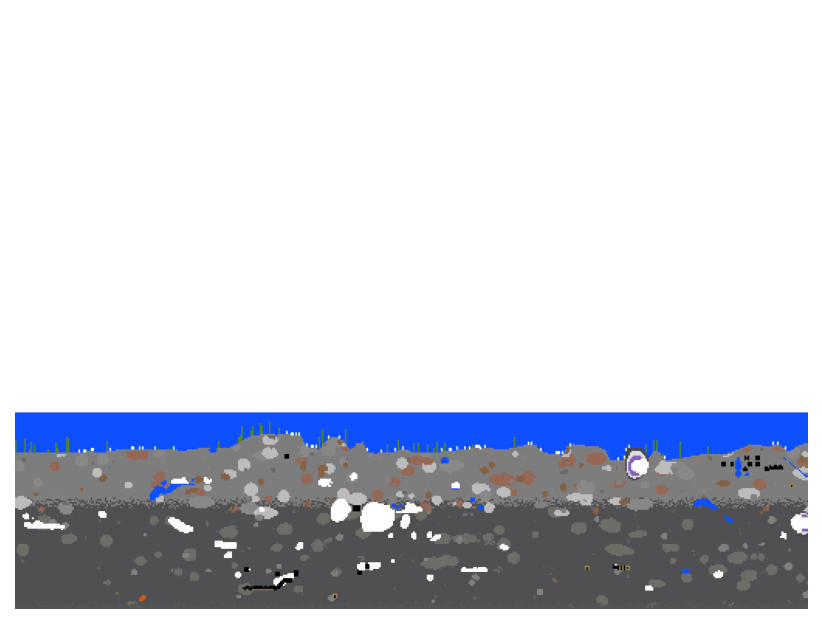

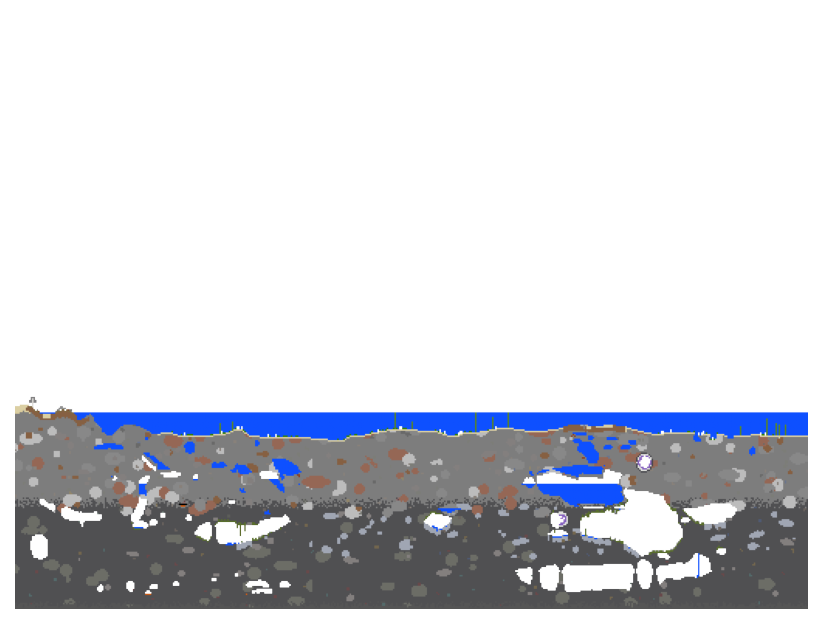

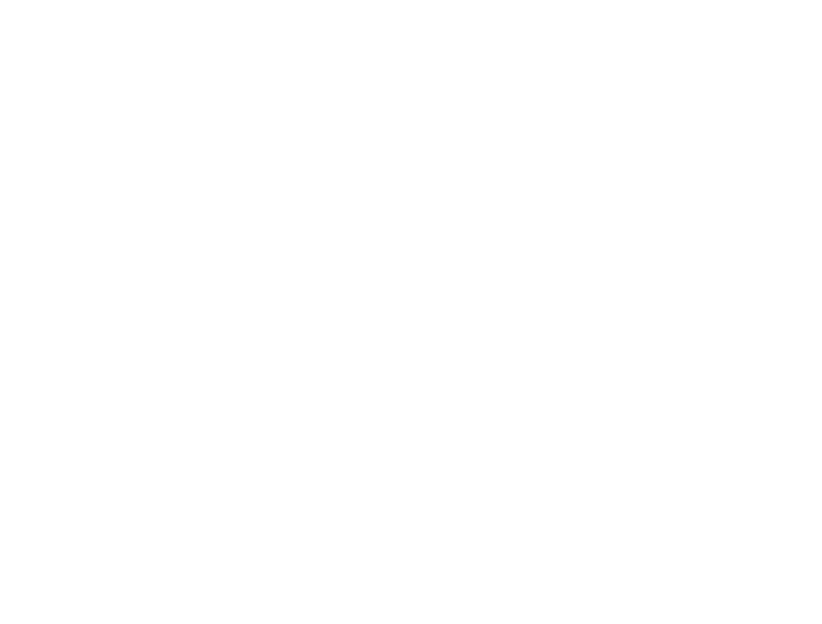

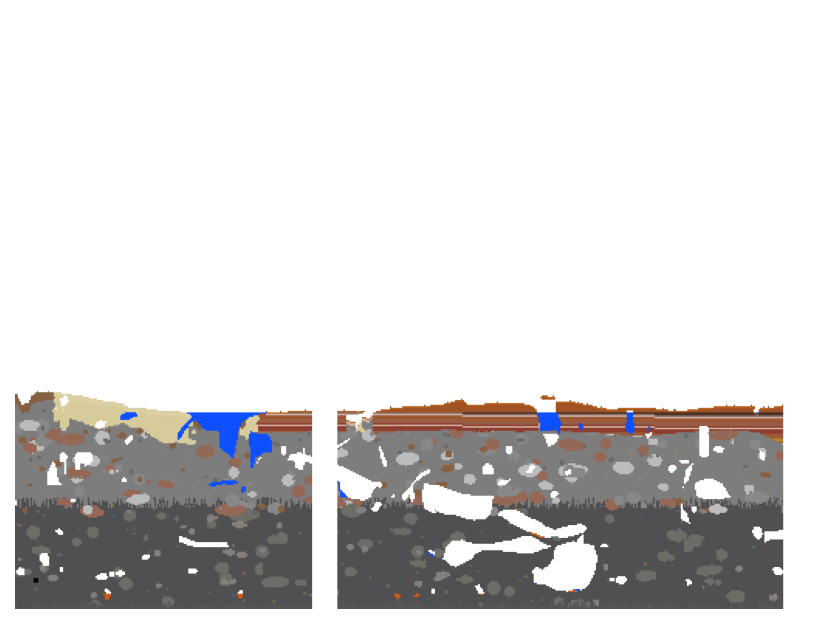

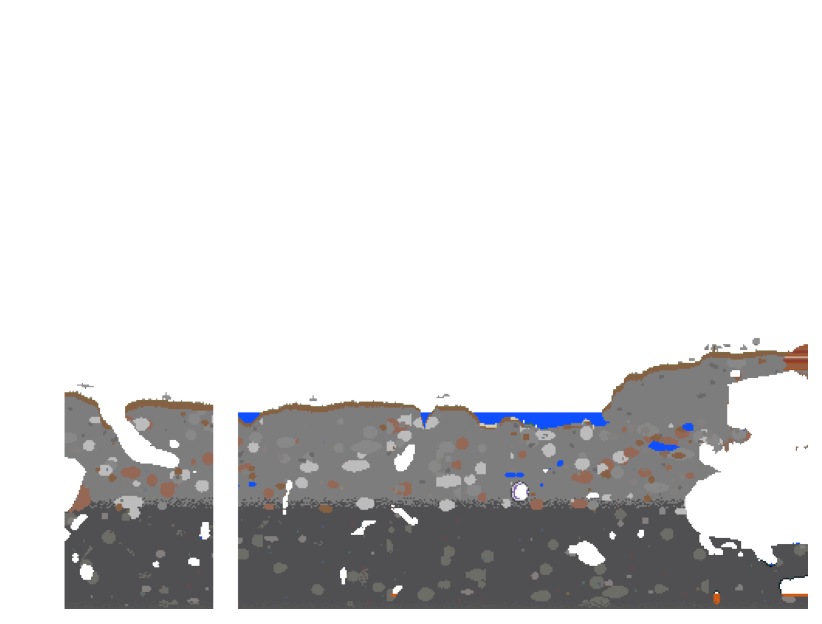

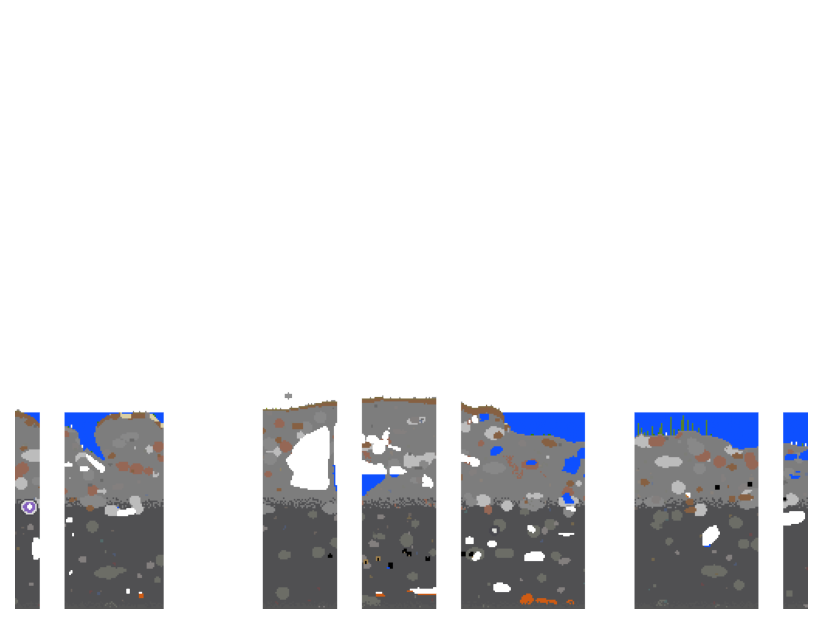

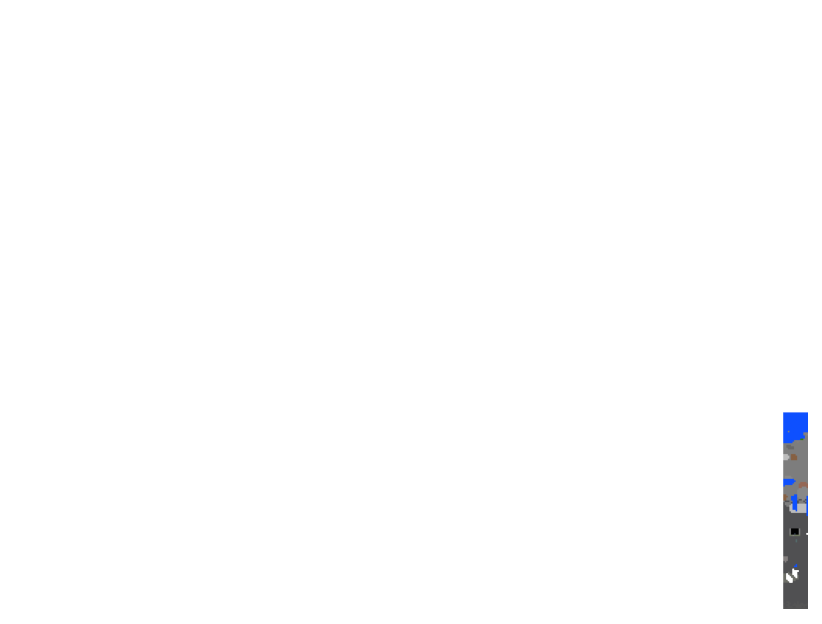

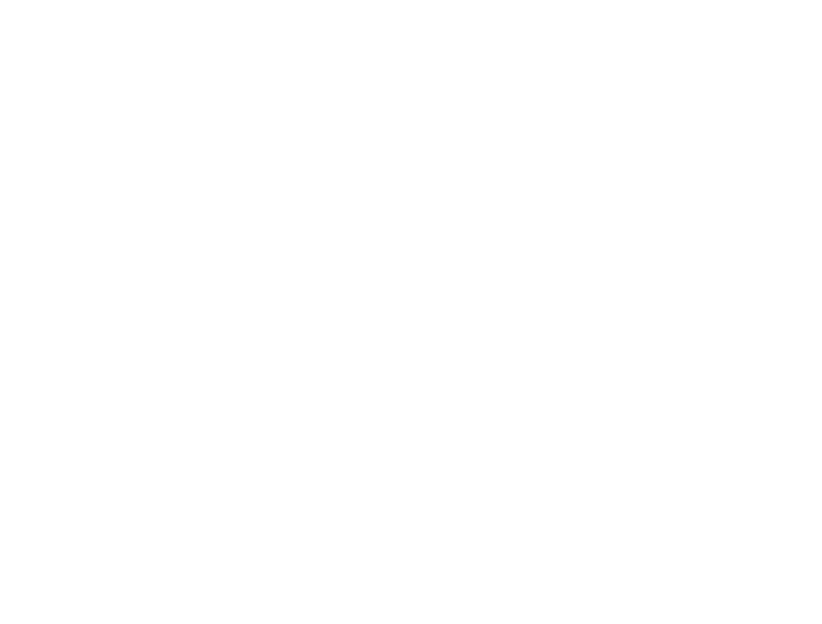

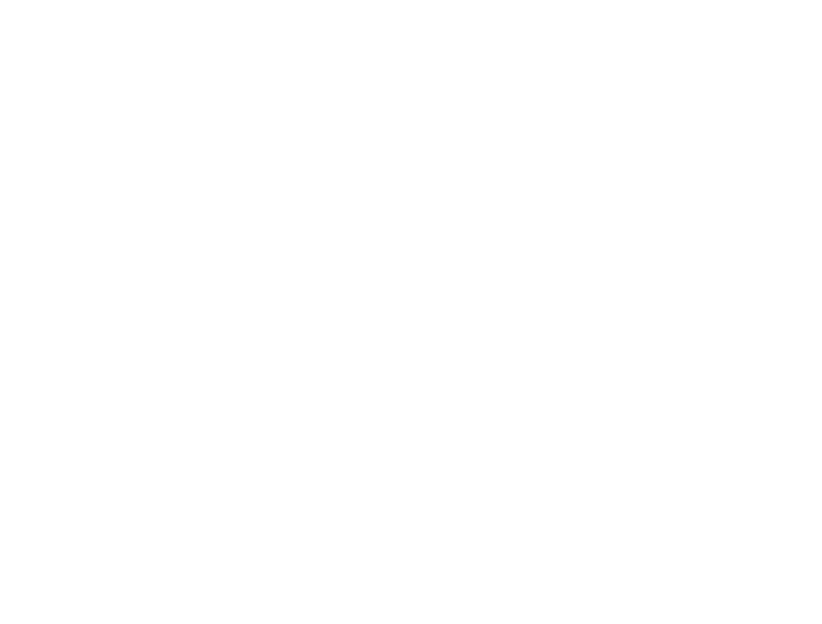

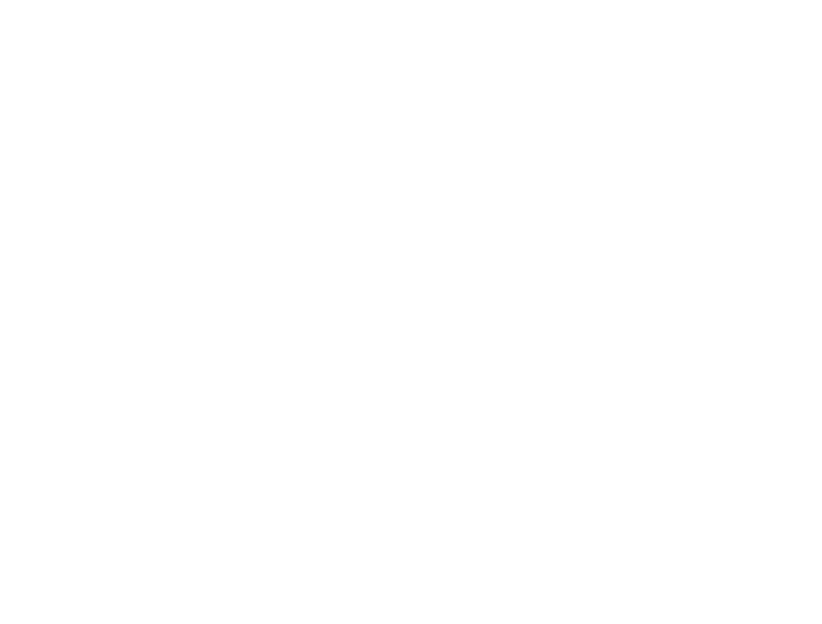

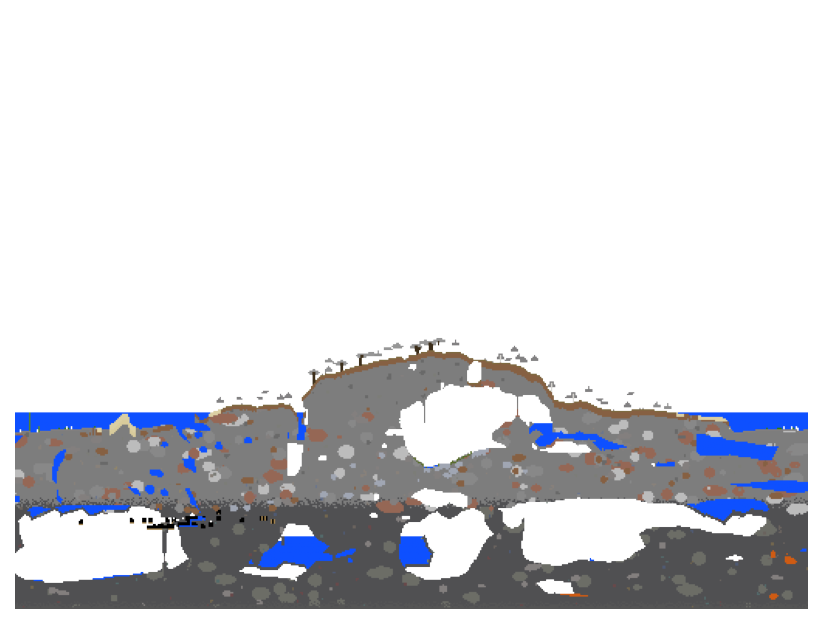

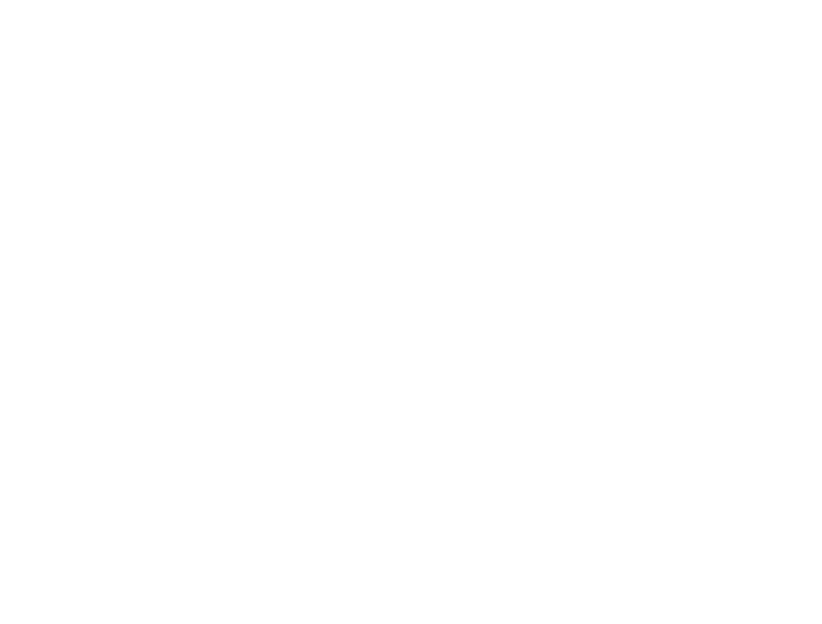

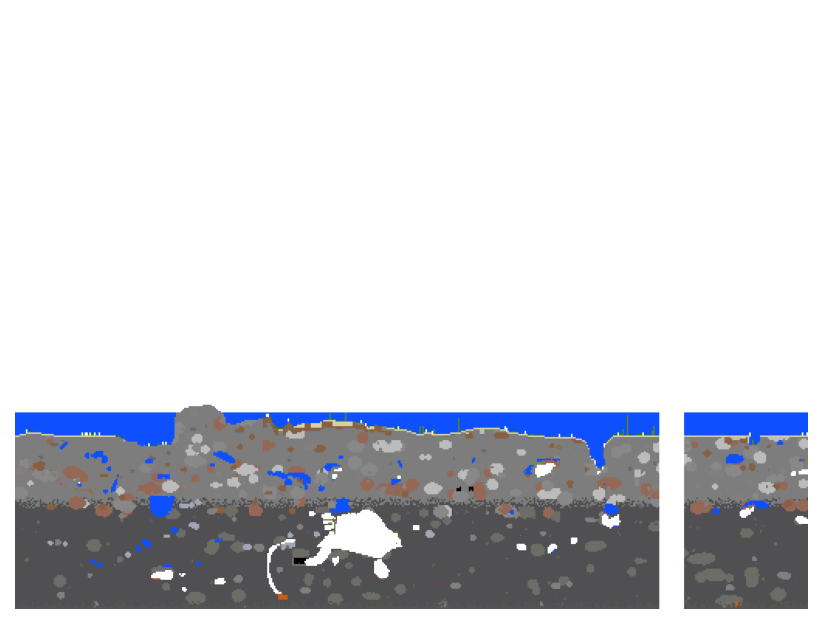

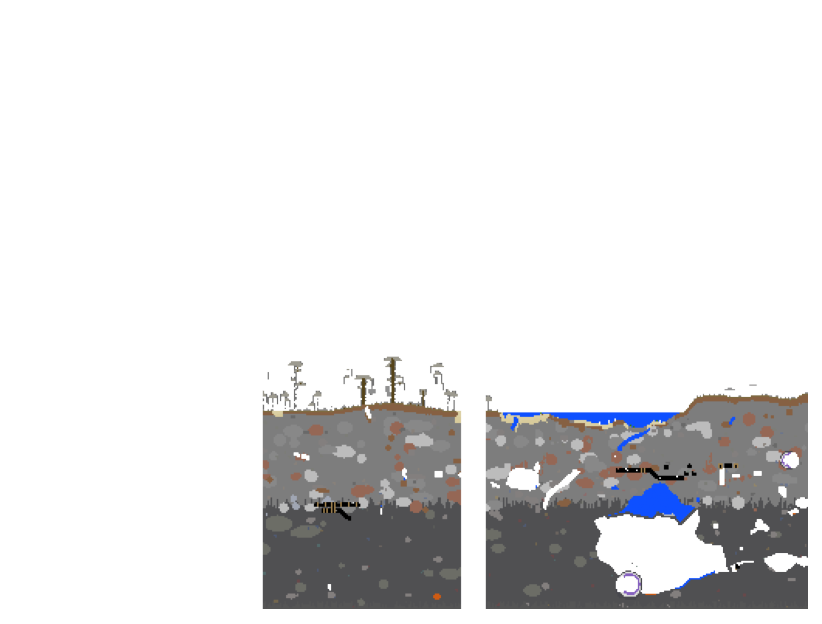

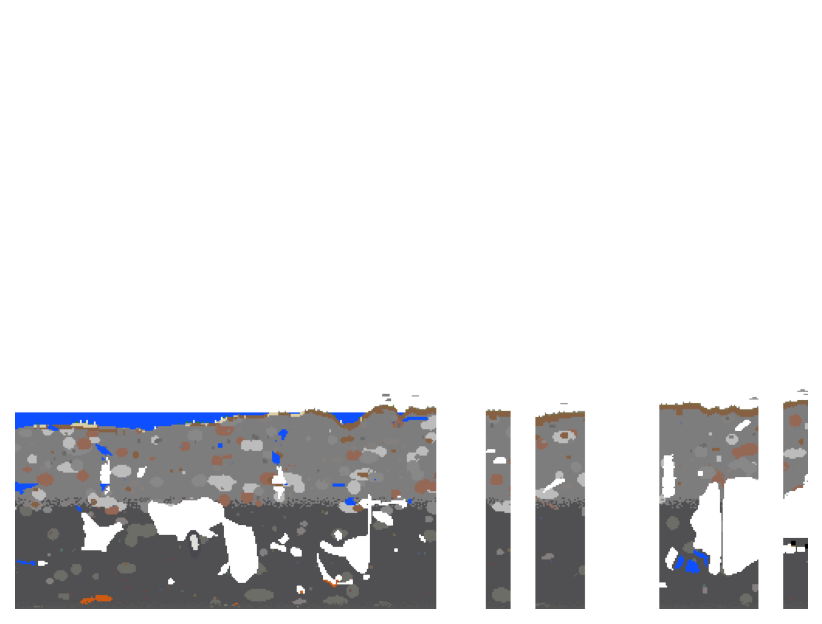

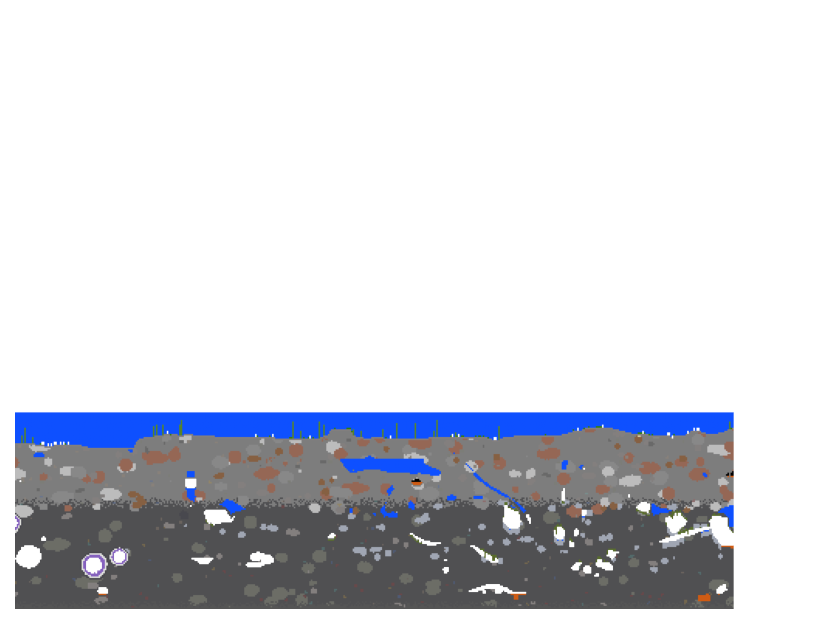

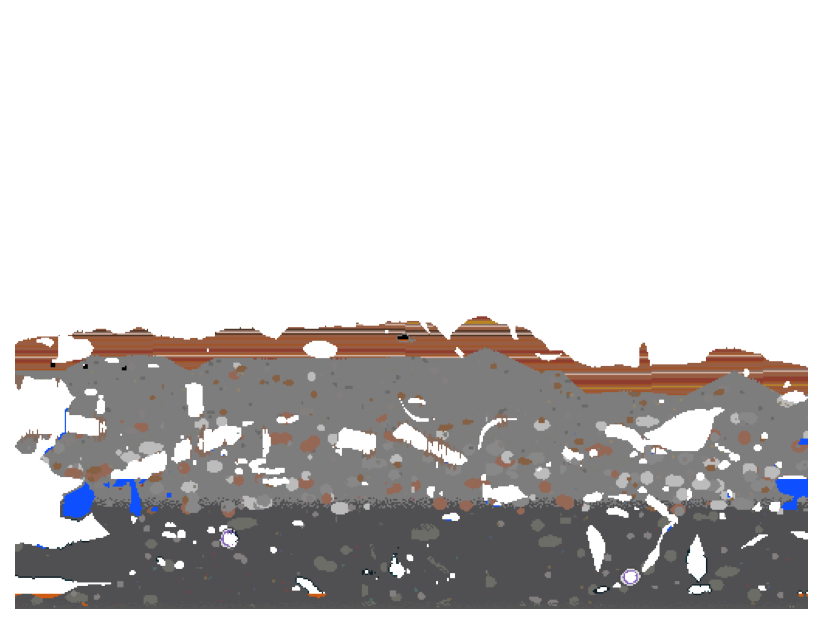

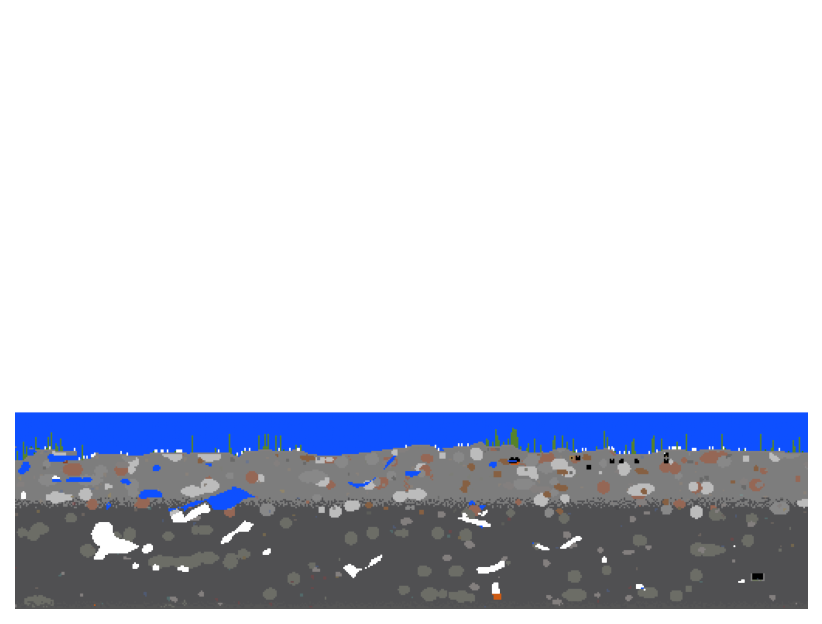

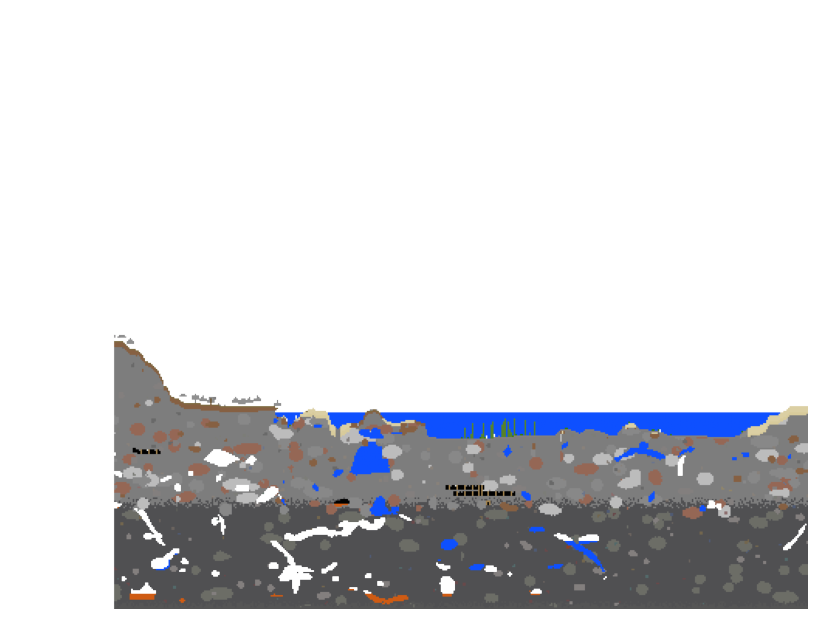

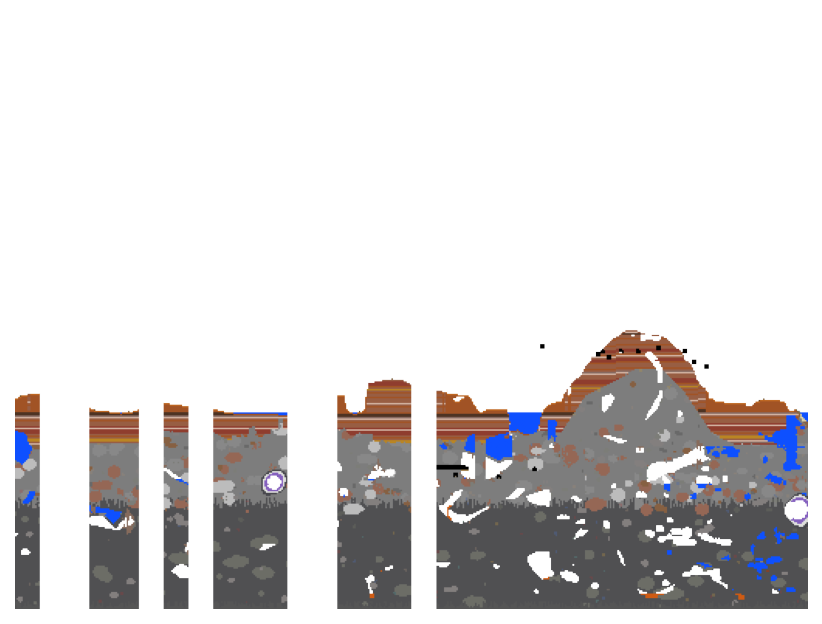

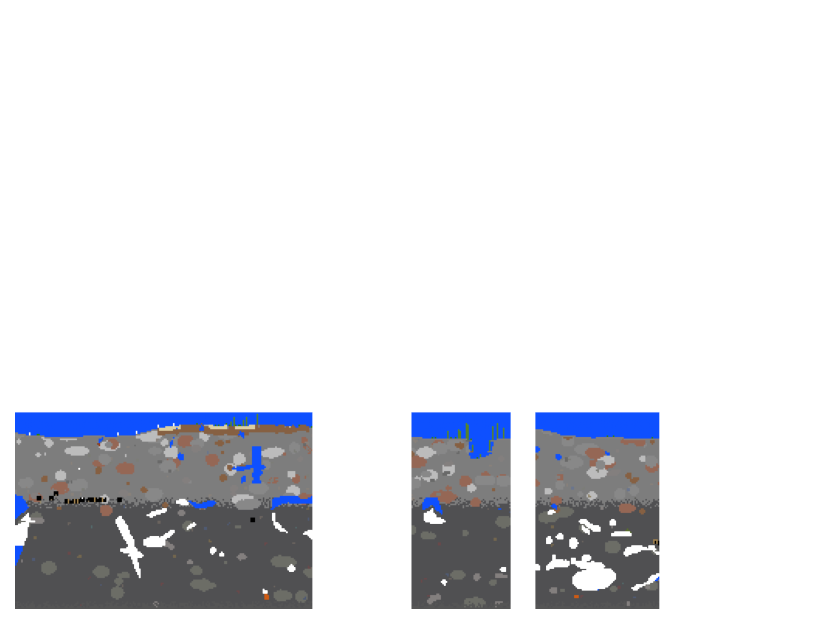

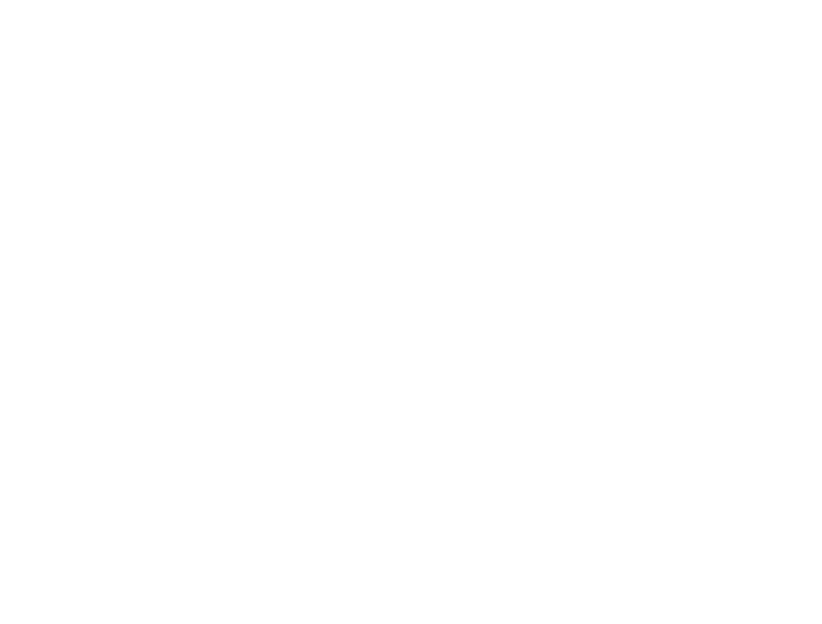

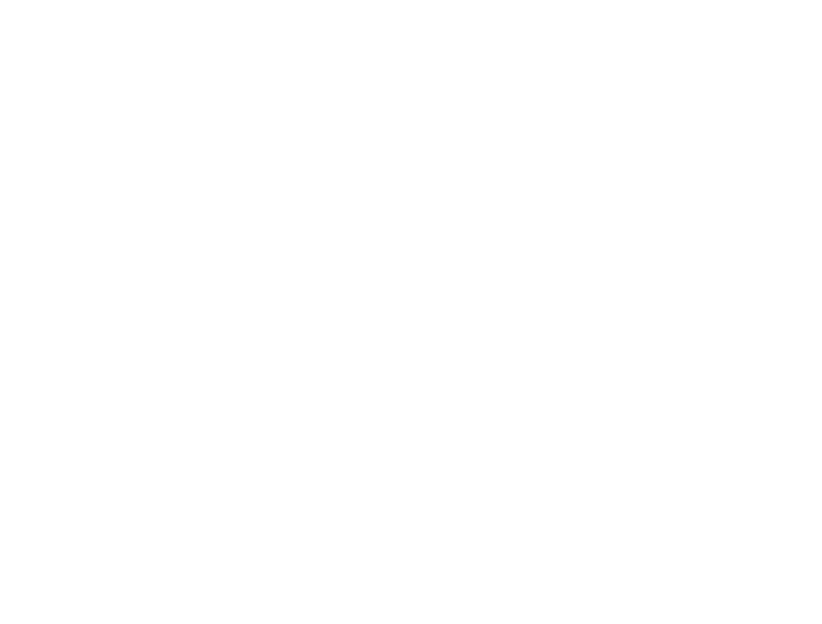

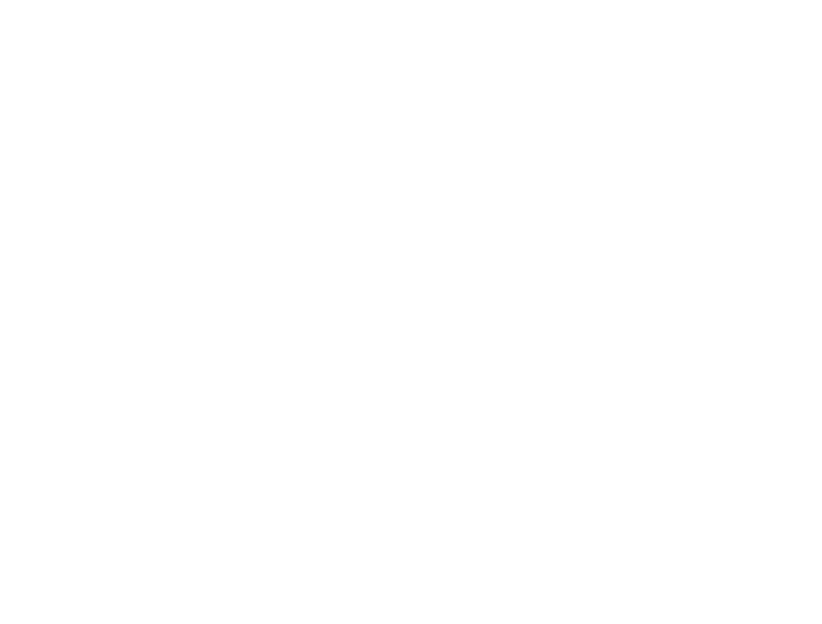

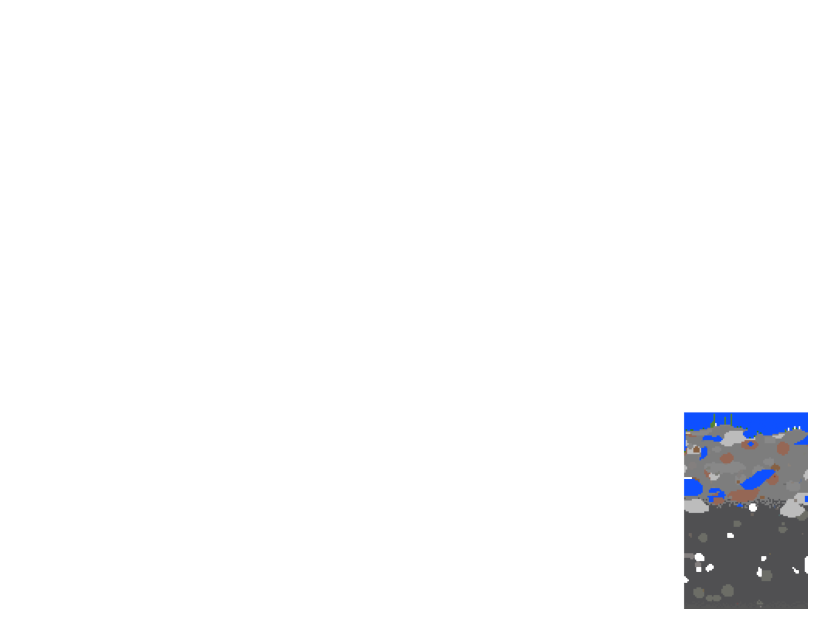

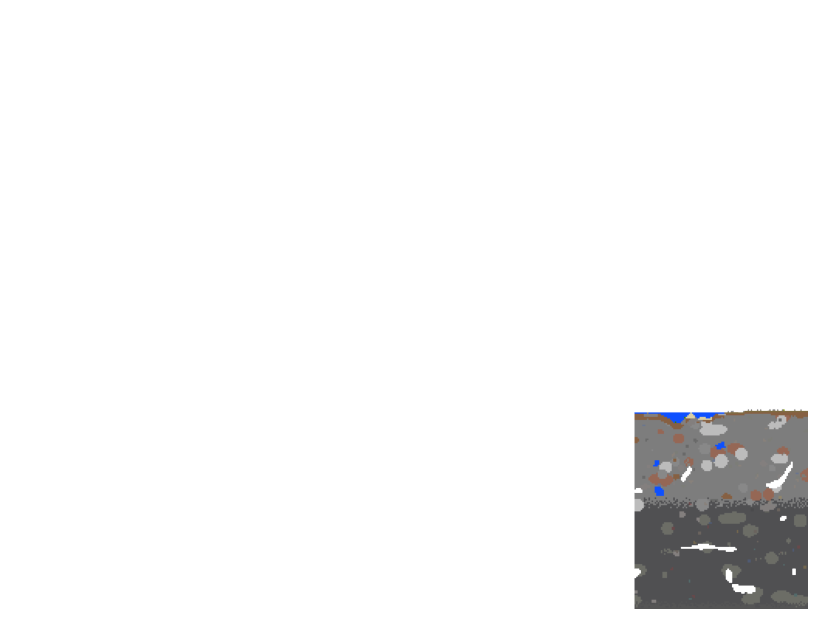

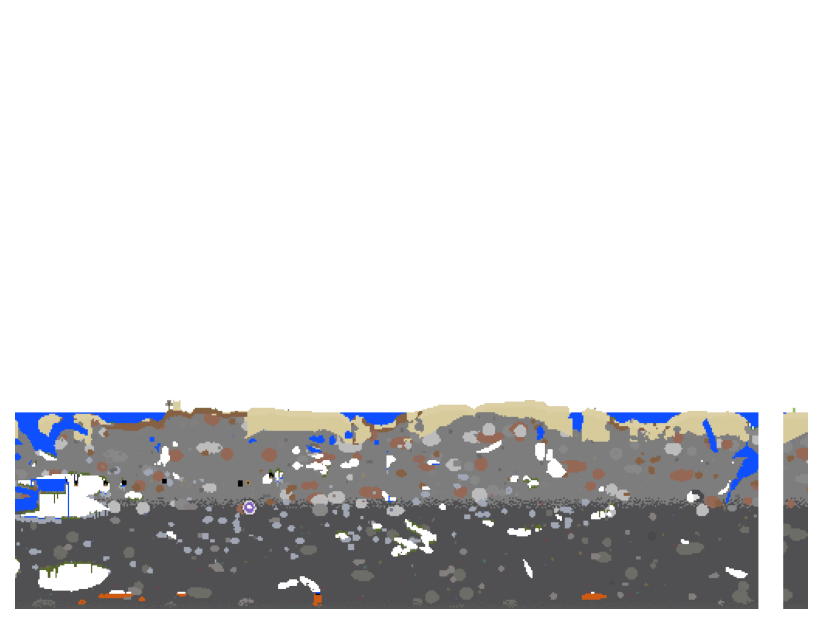

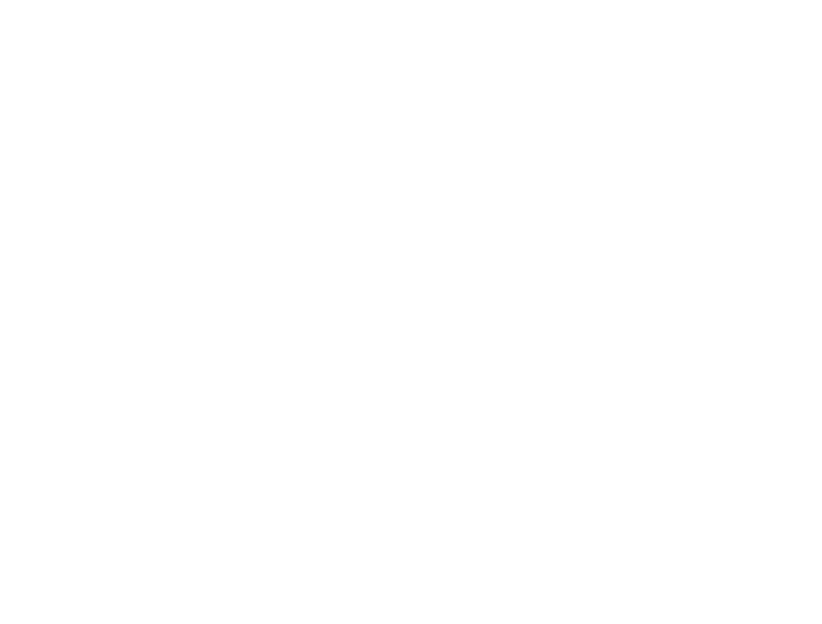

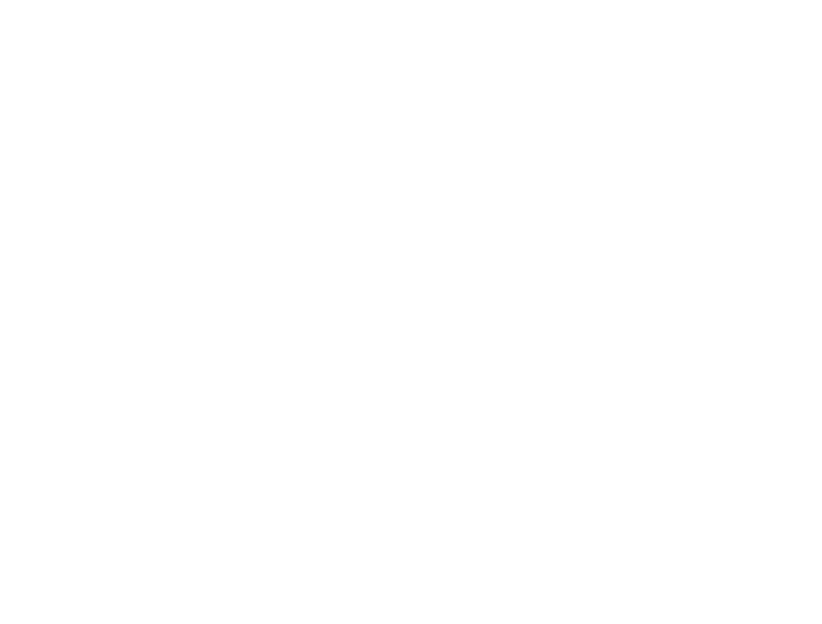

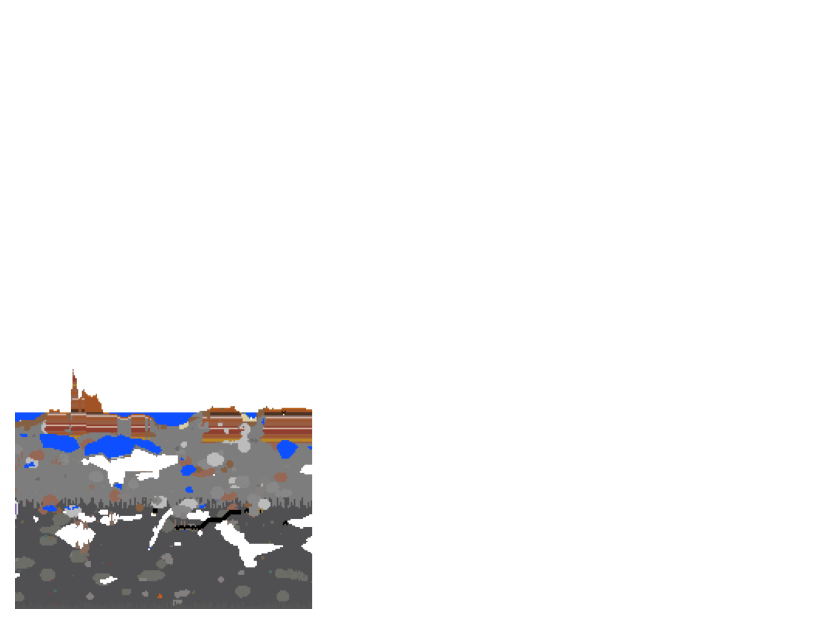

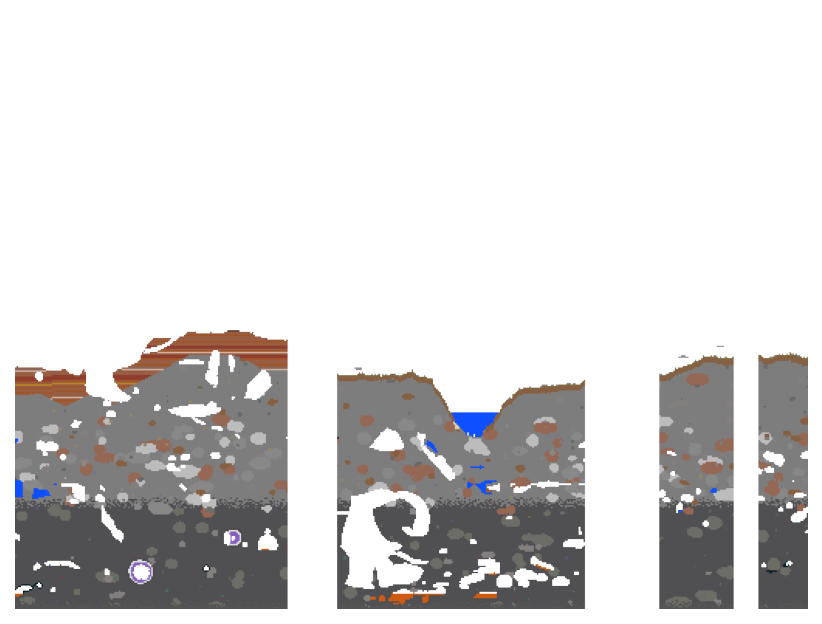

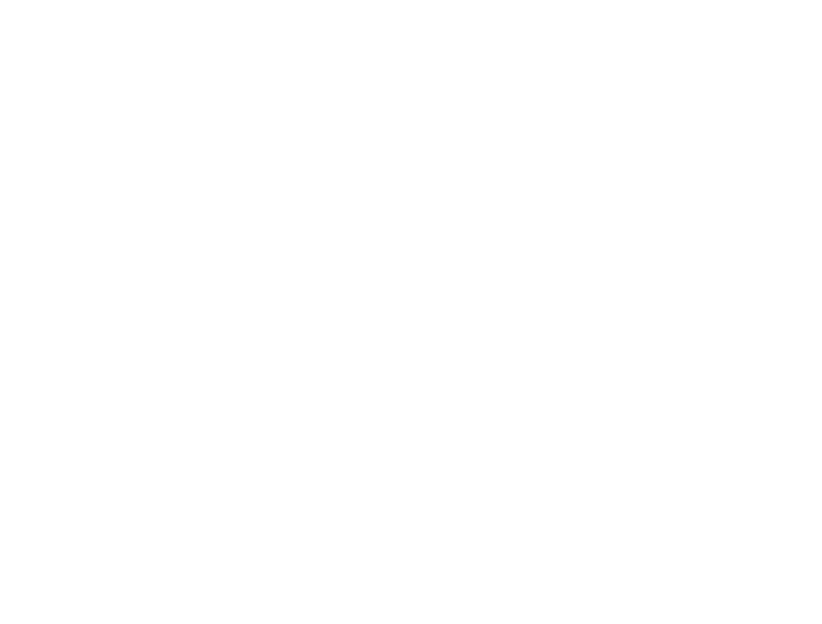

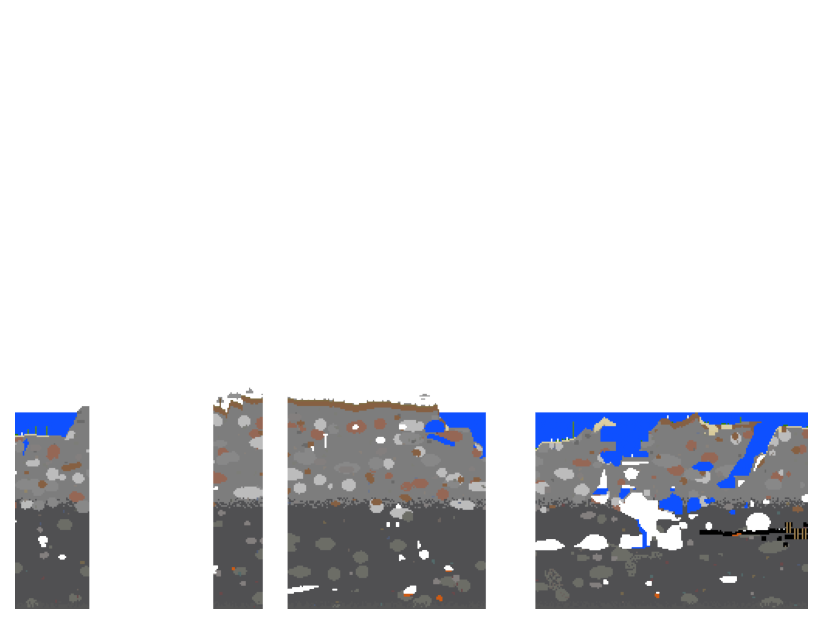

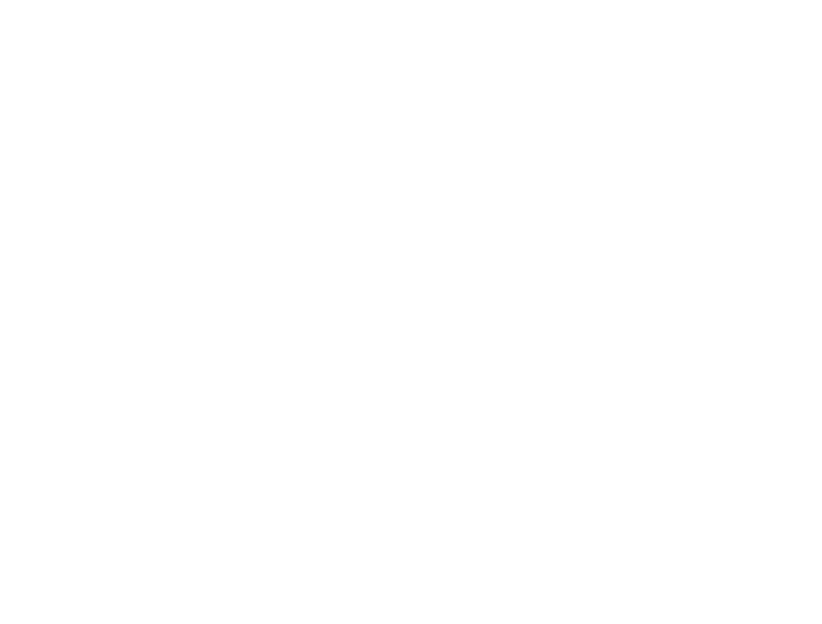

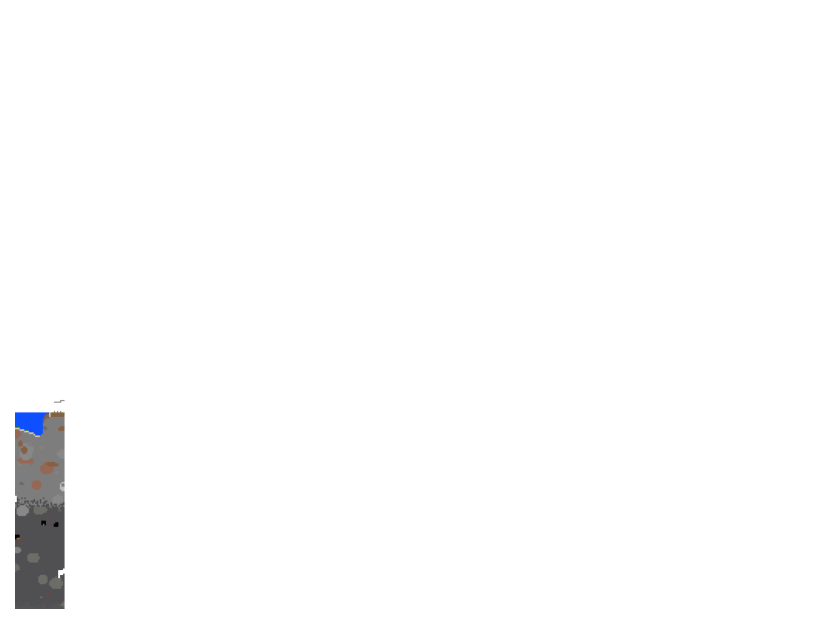

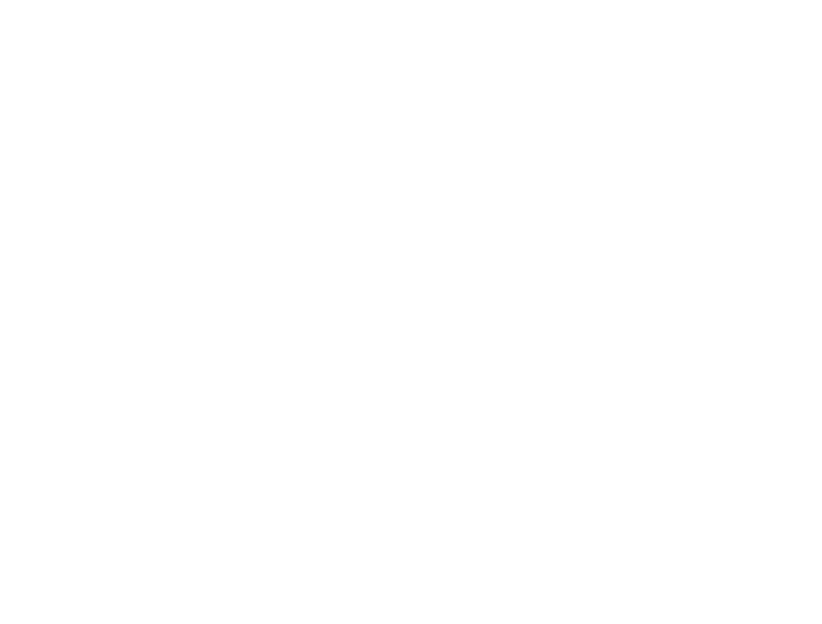

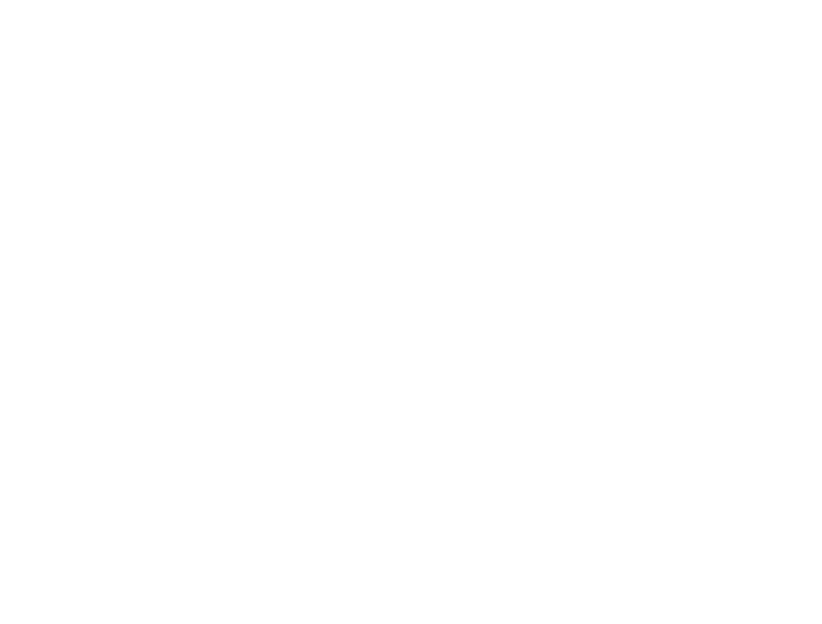

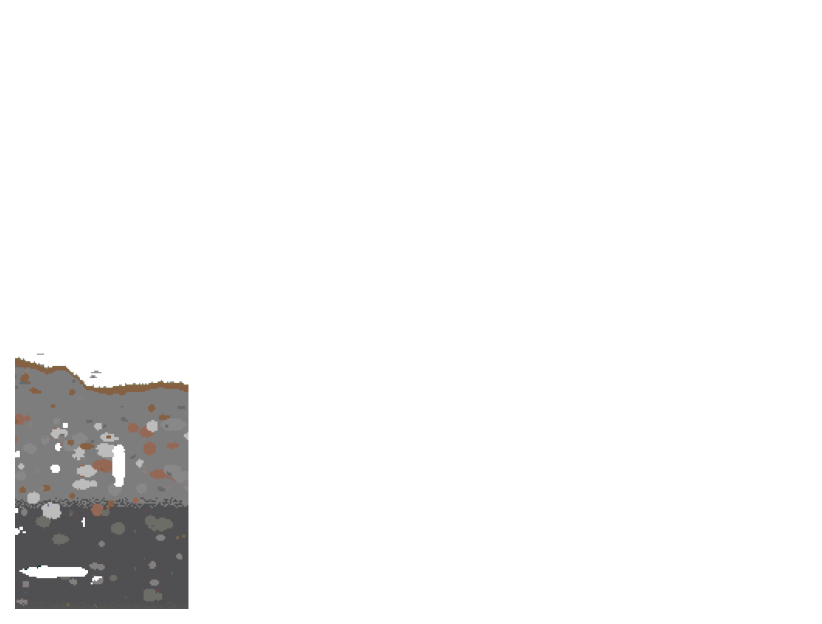

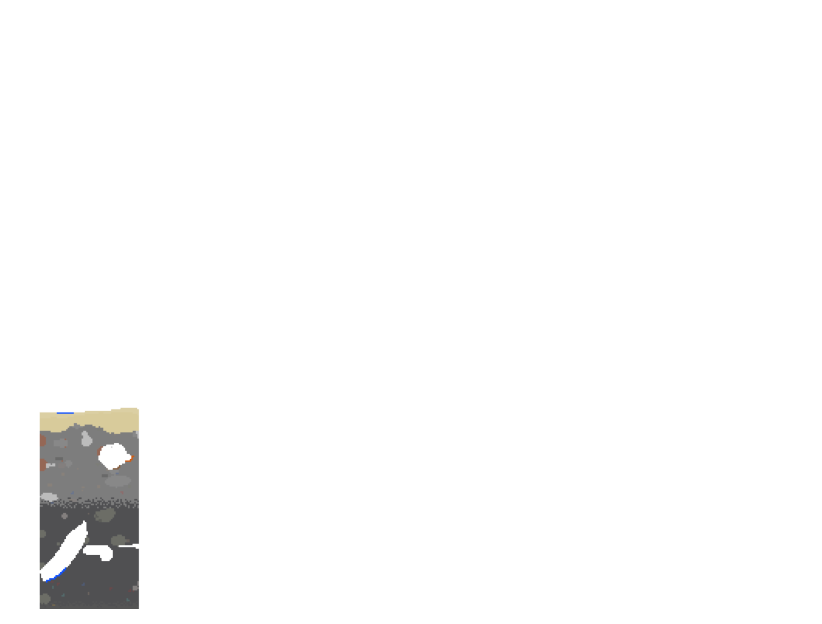

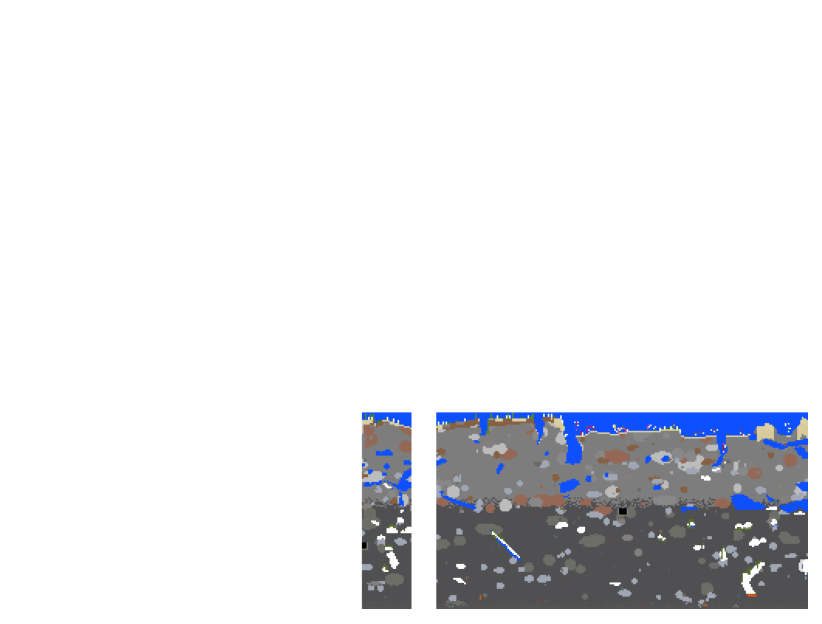

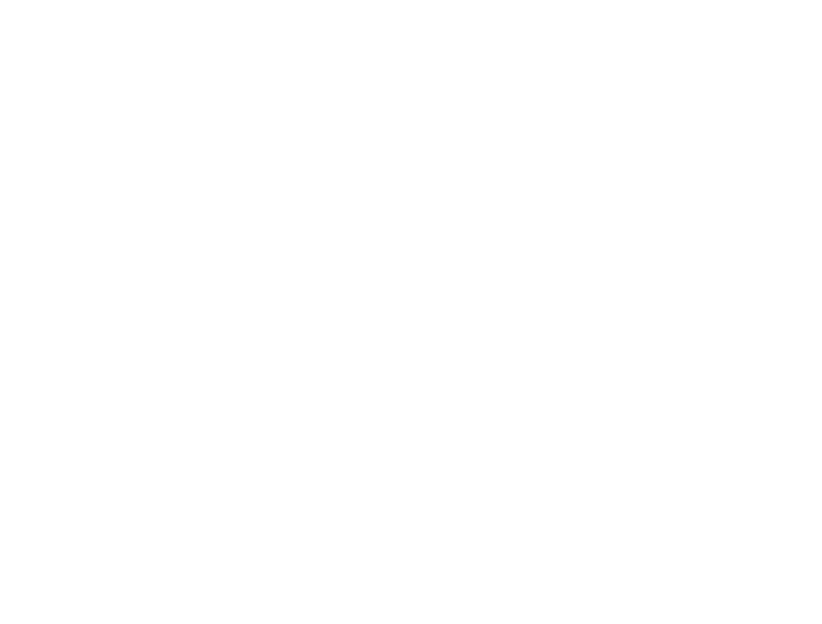

In [16]:
for ( x_region, z_region ), img in region_imgs.items():

    fig = plt.figure()
    ax = plt.gca()

    ax.imshow( np.rot90( img, axes=(0,1) ) )

    ax.set_aspect( 'equal' )
    ax.set_axis_off()